# iMaterialist (Fashion) 2019 at FGVC6
https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from util import *

In [3]:
path = Path('/home/jupyter/comp/')
# path.ls()

In [4]:
path_lbl = path/'labels'
path_img = path/'train'
path_test = path/'test'
if  not os.path.isdir(path_lbl):
    os.makedirs(path_lbl)
    
# category is in util
size = 224               # <---------------- HERE
CYCLE = 10

# get and show categories
with open(path/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(label_names)

# df loading takes a while

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']


In [5]:
# train dataframe
df = pd.read_csv(path/'train.csv')


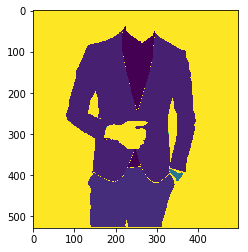

In [6]:

img_name = "53d0ee82b3b7200b3cec8c3c1becead9.jpg"

img_df = df[df.ImageId == img_name]
img_mask = ImageMask()
mask = img_mask.make_mask_img(img_df)

# img_mask = make_mask_img(img_df)
plt.imshow(mask)

# Start processing

In [7]:
images = df.ImageId.unique()    # <---------------- HERE

# Create label with dir

In [8]:
# create_label(df, images, path_lbl)

# Create Learner

In [9]:
get_y_fn = lambda x: path_lbl/f'{Path(x).stem}_P.png'

bs = 32
#classes = label_names
classes = list(range(category_num))
wd = 1e-2

images_df = pd.DataFrame(images)


src = (SegmentationItemList.from_df(images_df, path, folder='train')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=classes)
       .add_test_folder('test')
     )


In [10]:
def no_tfms(self, x, size, resize_method): return x
EmptyLabel.apply_tfms = no_tfms

data = (src.transform(tfms=get_transforms(), size=size, resize_method=ResizeMethod.SQUISH, tfm_y=True)
       .databunch(bs=bs,num_workers=4)
        .normalize(imagenet_stats)
       )

In [11]:
# I create an accuracy metric which excludes the background pixels
# not sure if this is correct

def acc_fashion(input, target):
    target = target.squeeze(1)
    mask = target != (category_num - 1)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

learn = unet_learner(data, models.resnet34, metrics=acc_fashion, wd=wd, )

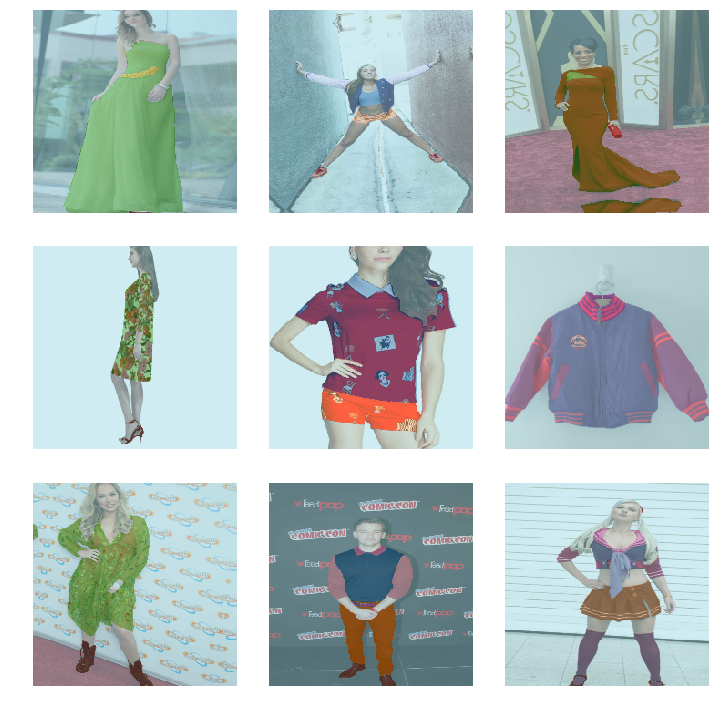

In [12]:
# look at a batch
data.show_batch(3, figsize=(10,10))

# Stop here during analysis. Training session.

In [13]:
# find lr

# lr_find(learn)
# learn.recorder.plot()

In [14]:
lr=1e-4
for i in range(CYCLE):
    print("Training for {}".format(i))
    learn.fit_one_cycle(1, slice(lr), pct_start=0.9)
    learn.save('After {0}'.format(size))


Training for 0


epoch,train_loss,valid_loss,acc_fashion,time
0,0.498565,0.431996,0.513109,1:38:13


Training for 1


epoch,train_loss,valid_loss,acc_fashion,time
0,0.451246,0.389625,0.550421,1:42:00


Training for 2


epoch,train_loss,valid_loss,acc_fashion,time
0,0.420262,0.366555,0.572464,1:41:40


Training for 3


epoch,train_loss,valid_loss,acc_fashion,time
0,0.388314,0.352216,0.586468,1:40:33


Training for 4


epoch,train_loss,valid_loss,acc_fashion,time
0,0.371941,0.342333,0.599763,1:40:45


Training for 5


epoch,train_loss,valid_loss,acc_fashion,time
0,0.373205,0.331838,0.612515,1:40:50


Training for 6


epoch,train_loss,valid_loss,acc_fashion,time
0,0.350539,0.326770,0.621924,1:38:12


Training for 7


epoch,train_loss,valid_loss,acc_fashion,time
0,0.350180,0.318796,0.631755,1:37:37


Training for 8


epoch,train_loss,valid_loss,acc_fashion,time
0,0.316770,0.315351,0.631289,1:37:27


Training for 9


epoch,train_loss,valid_loss,acc_fashion,time
0,0.329724,0.313894,0.633364,1:38:30


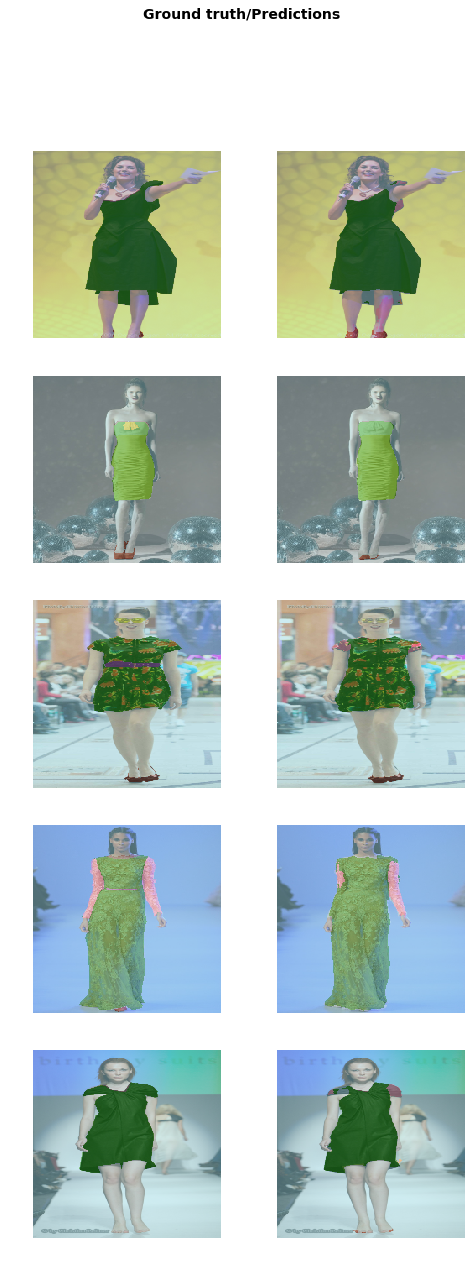

In [15]:
# take a look at some results
learn.show_results()

In [ ]:
# unfreeze earlier weights
# decrease the learning rate
# train for 10 more cycles unfrozen

learn.unfreeze()
lrs = slice(lr/400,lr/4)

for i in range(CYCLE):
    print("Training for {}".format(i))
    learn.fit_one_cycle(1, slice(lr/400,lr/4) , pct_start=0.8)
    learn.save('Unfreeze After {0}'.format(size))

Training for 0


epoch,train_loss,valid_loss,acc_fashion,time
0,0.287019,0.308520,0.640875,1:37:50


Training for 1


epoch,train_loss,valid_loss,acc_fashion,time
0,0.268444,0.308317,0.641130,1:36:22


Training for 2


epoch,train_loss,valid_loss,acc_fashion,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training for 4


epoch,train_loss,valid_loss,acc_fashion,time
0,0.255235,0.312418,0.646471,1:36:11


Training for 5


epoch,train_loss,valid_loss,acc_fashion,time
0,0.252087,0.313376,0.645453,1:37:57


Training for 6


epoch,train_loss,valid_loss,acc_fashion,time


In [ ]:
# learn.save('After {0}'.format(size))

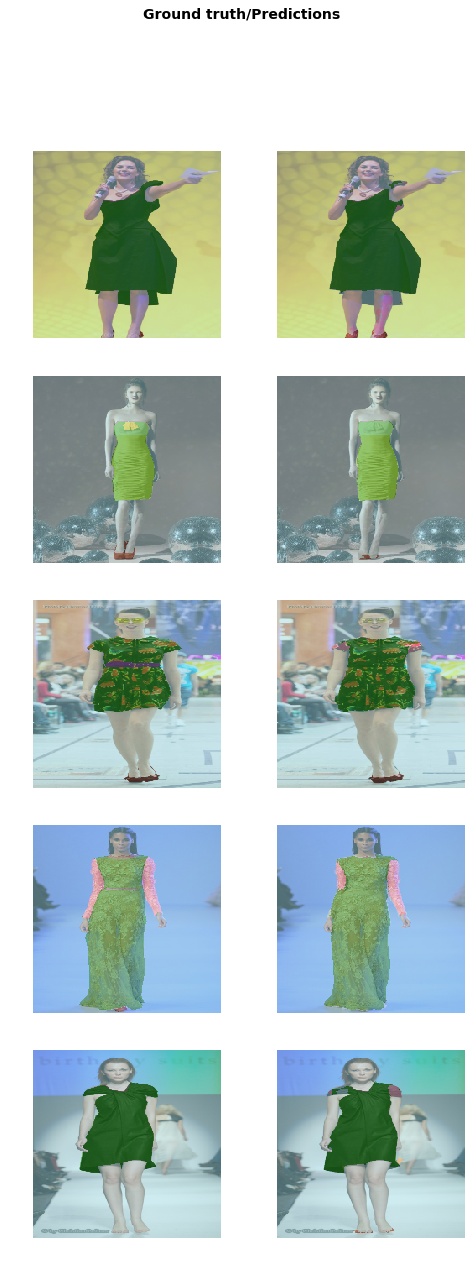

In [19]:
# more results

learn.show_results()

In [20]:
size = 512           # <------------ HERE
bs = 16

In [1]:
data = (src.transform(tfms=get_transforms(), size=size, resize_method=ResizeMethod.SQUISH, tfm_y=True)
       .databunch(bs=bs,num_workers=4)
        .normalize(imagenet_stats)
       )
learn = unet_learner(data, models.resnet34, metrics=acc_fashion, wd=wd, )

NameError: name 'src' is not defined

In [23]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 15.90 GiB total capacity; 13.30 GiB already allocated; 995.88 MiB free; 1003.95 MiB cached)

In [ ]:
lr=1e-3
for i in range(CYCLE):
    print("Training for {}".format(i))
    learn.fit_one_cycle(1, slice(lr), pct_start=0.8)
    learn.save('After {0}'.format(size))


In [ ]:
# learn.save('After {0}'.format(size))

# Loading previously saved model

In [ ]:
# temp = learn.load('without_unfreeze-31may')

# Do prediction & get encoded result ready for submission

In [ ]:
pred_size = 512
predicts = get_predictions(path_test, learn, pred_size)

In [ ]:
submission_df = get_submission_df(predicts)
submission_df.to_csv("./submission-{}.csv".format(size), index=False)

# TODO: 
training size & testing size should be different

In [ ]:
"{}.csv".format(size)

In [24]:
free = gpu_mem_get_free_no_cache()
free

995